In [1]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA,SparsePCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials, select_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
from ephysvibe.task import task_constants
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy import stats
seed=2024

In [2]:
def get_visual_fr(sp, start):
    if np.nansum(sp[:, : start + 250]) == 0:
        return np.nan, np.nan
    avgtr_fr = np.mean(sp, axis=0)
    bl_avg = np.mean(avgtr_fr[:start])
    avg_fr = avgtr_fr - bl_avg
    vr = np.mean(avg_fr[start + 50 : start + 250] * 1000)  # vis response

    g1 = np.mean(sp[:, :start], axis=1)
    g2 = np.mean(sp[:, start : start + 250], axis=1)
    p = stats.ranksums(g1, g2)[1]
    sig = p < 0.5
    return vr, sig

In [65]:
def get_unit(path,time_before,start,end):
    neu_data = NeuronData.from_python_hdf5(path)

    # get spike matrices in and out conditions
    sp_in, mask_in = align_trials.get_align_tr(
        neu_data, select_block=1, select_pos=1, time_before=time_before,event="sample_on"
    )
    idx_start = time_before + start 
    idx_end = time_before+end
    sp_vr_in = sp_in[neu_data.sample_id[mask_in] != 0,idx_start:]
    vr_in, vr_in_sig = get_visual_fr(sp=sp_vr_in, start=abs(start))
    sp_samples = select_trials.get_sp_by_sample(sp_in[:,:idx_end+200], neu_data.sample_id[mask_in], samples=[0,11,15,55,51])
    sp_samples['path']=path
    sp_samples['unit_type']=neu_data.cluster_group
    sp_samples['n_type']=neu_data.cluster_number
    sp_samples['vr_in']=vr_in
    sp_samples['vr_in_sig']=vr_in_sig
    return sp_samples

In [23]:
if platform.system() == "Linux":
    basepath = (
        "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/"
    )
elif platform.system() == "Windows":
    basepath = 'D:/data/'#"C:/Users/camil/Documents/int/"

In [41]:
session = '2022-12-05_10-51-52'
areas=['v4']
subject='Riesling'
time_before=700
select_block=1
start=-200
end=1500
idx_start = time_before + start 
idx_end = time_before+end

In [42]:
units_info = {'v4':{},'pfc':{}}
for area in areas:
    neu_path = basepath + "session_struct/" + area + "/neurons/*neu.h5"
    path_list = np.array(glob.glob(neu_path))
    mask=[]
    for path in path_list:
        mask.append(session == path.replace("\\", "/").rsplit("/")[-1].rsplit("_" + subject)[0])
    path_list=path_list[mask]
    units_info[area]['paths']=path_list

In [43]:
area_info={}
for area in areas:
    path_list = units_info[area]['paths']

    info = Parallel(n_jobs=-1)(
        delayed(get_unit)(path_list[i],time_before=time_before,start=start,end=end)for i in tqdm(range(len(path_list)))
    )
    area_info[area] = info

100%|██████████| 73/73 [00:22<00:00,  3.30it/s]


In [44]:
for area in areas:
    paths,n_type,unit_type,vr_in,vr_in_sig=[],[],[],[],[]
    sp11=[]
    sp15=[]
    sp51=[]
    sp55=[]
    sp0=[]
    for i_info in area_info[area]:
        if i_info is not None:
            paths.append(i_info['path'])
            sp11.append(i_info['11'])
            sp15.append(i_info['15'])
            sp51.append(i_info['51'])
            sp55.append(i_info['55'])
            sp0.append(i_info['0'])
            n_type.append(i_info['n_type'])
            unit_type.append(i_info['unit_type'])
            vr_in.append(i_info['vr_in'])
            vr_in_sig.append(i_info['vr_in_sig'])
    units_info[area]['paths'] = np.array(paths)
    units_info[area]['11'] = np.array(sp11)
    units_info[area]['15'] = np.array(sp15)
    units_info[area]['51'] = np.array(sp51)
    units_info[area]['55'] = np.array(sp55)
    units_info[area]['0'] = np.array(sp0)
    units_info[area]['unit_type'] = np.array(unit_type)
    units_info[area]['n_type'] = np.array(n_type)
    units_info[area]['vr_in']=np.array(vr_in)
    units_info[area]['vr_in_sig']=np.array(vr_in_sig)

In [45]:
area

'v4'

In [46]:
units_info[area]['11'][0].shape

(51, 2200)

In [47]:
units_info[area]['unit_type'][0]

'good'

In [48]:
units_info[area]['n_type'][0]

14

In [49]:
def moving_average(data: np.ndarray, win: int, step: int = 1) -> np.ndarray:
    d_shape = data.shape
    count = 0
    win=int(np.floor(win/2))
    if len(d_shape) == 3:
        d_avg = np.zeros((d_shape[0], d_shape[1], int(np.floor(d_shape[2] / step))))
        for i_step in np.arange(0, d_shape[2] - step, step):
            st_win = 0 if i_step-win <0 else i_step-win
            d_avg[:, :, count] = np.mean(data[:, :, st_win : i_step + win], axis=2)
            count += 1
    if len(d_shape) == 2:
        d_avg = np.zeros((d_shape[0], int(np.floor(d_shape[1] / step))))
        for i_step in np.arange(0, d_shape[1] - step, step):
            st_win = 0 if i_step-win <0 else i_step-win
            d_avg[:, count] = np.mean(data[:, st_win : i_step + win], axis=1)
            count += 1
    if len(d_shape) == 1:
        d_avg = np.zeros((int(np.floor(d_shape[0] / step))))
        for i_step in np.arange(0, d_shape[0] - step, step):
            st_win = 0 if i_step-win <0 else i_step-win
            d_avg[count] = np.mean(data[st_win : i_step + win], axis=0)
            count += 1
    return d_avg

In [50]:
units_info[area]['11'].shape

(73, 51, 2200)

In [59]:
i_n=0

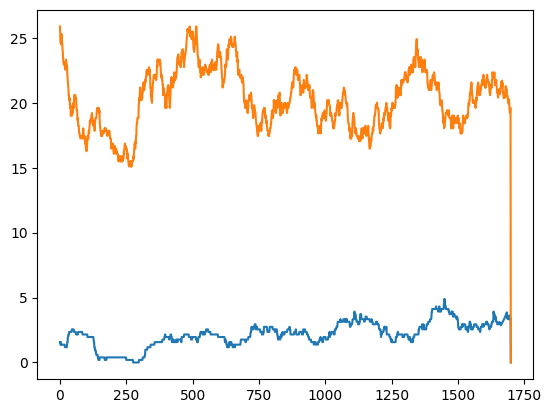

In [60]:
fr=units_info[area]['11'][i_n]
avg_fr=moving_average(data=fr, win=100, step=1)
avgtr_fr=np.mean(avg_fr,axis=0)
plt.plot(avgtr_fr[idx_start:idx_end]*1000)

fr=units_info[area]['11'][i_n+1]
avg_fr=moving_average(data=fr, win=100, step=1)
avgtr_fr=np.mean(avg_fr,axis=0)
plt.plot(avgtr_fr[idx_start:idx_end]*1000)

In [53]:
i_n=20

visual response: -0.37


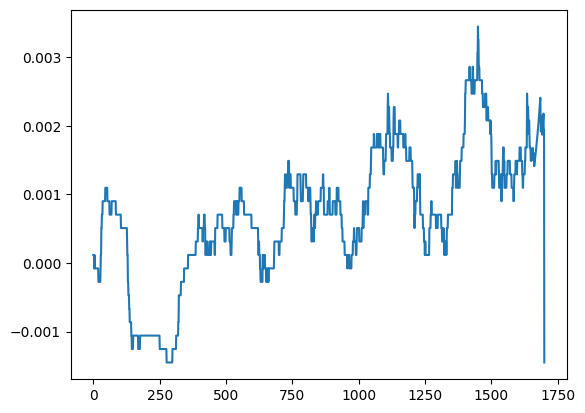

In [66]:
for i_n in range(1):
    fr=units_info[area]['11'][i_n]
    movavg_fr=moving_average(data=fr, win=100, step=1)
    avg_fr=np.mean(movavg_fr,axis=0)[idx_start:idx_end]#*1000
    avg_fr=avg_fr-np.mean(avg_fr[:abs(start)])
    plt.plot(avg_fr)
    print('visual response: %.2f'%np.mean(avg_fr[250:450]*1000))


In [55]:
colors = {'11':task_constants.PALETTE_B1['o1_c1'],'15':task_constants.PALETTE_B1['o1_c5'],'51':task_constants.PALETTE_B1['o5_c1'],'55':task_constants.PALETTE_B1['o5_c5'],'0':task_constants.PALETTE_B1['o0_c0']}

In [56]:
units_info[area].keys()

dict_keys(['paths', '11', '15', '51', '55', '0', 'unit_type', 'n_type', 'vr_in', 'vr_in_sig'])

C:\Users\camil\AppData\Local\Temp\ipykernel_21804\3906106873.py:10: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cols+start,rows+n_trials, marker='|', alpha=1,edgecolors='none',color=colors[key],label="sample %s" % key)


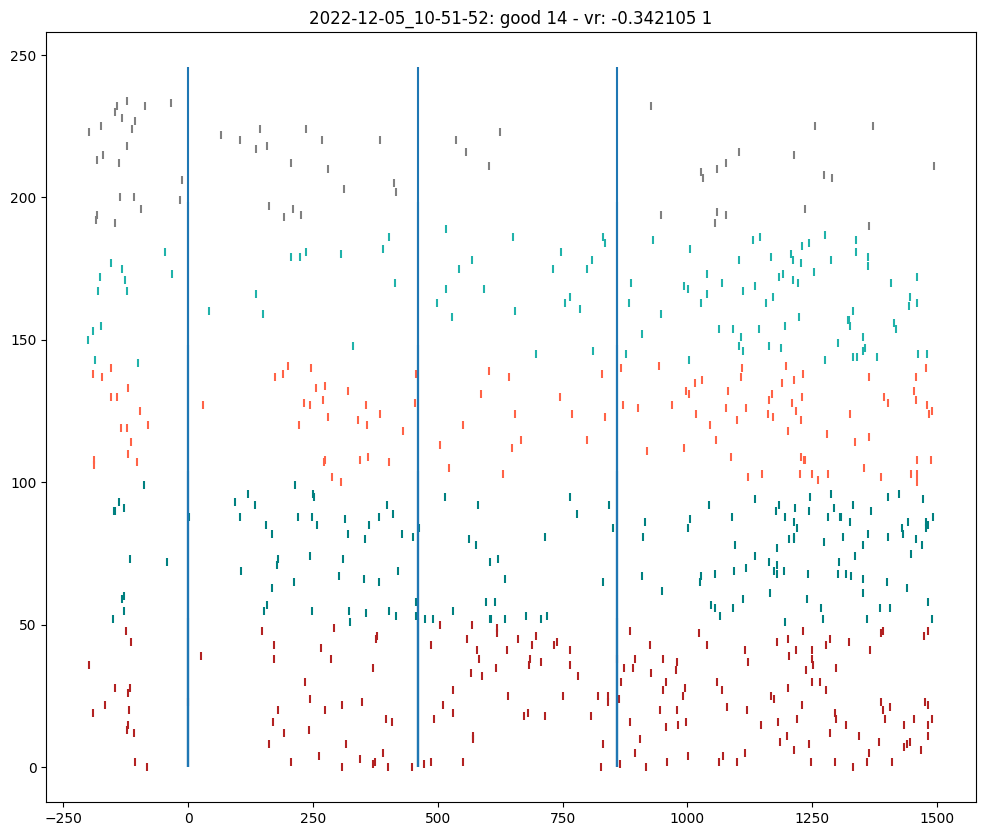

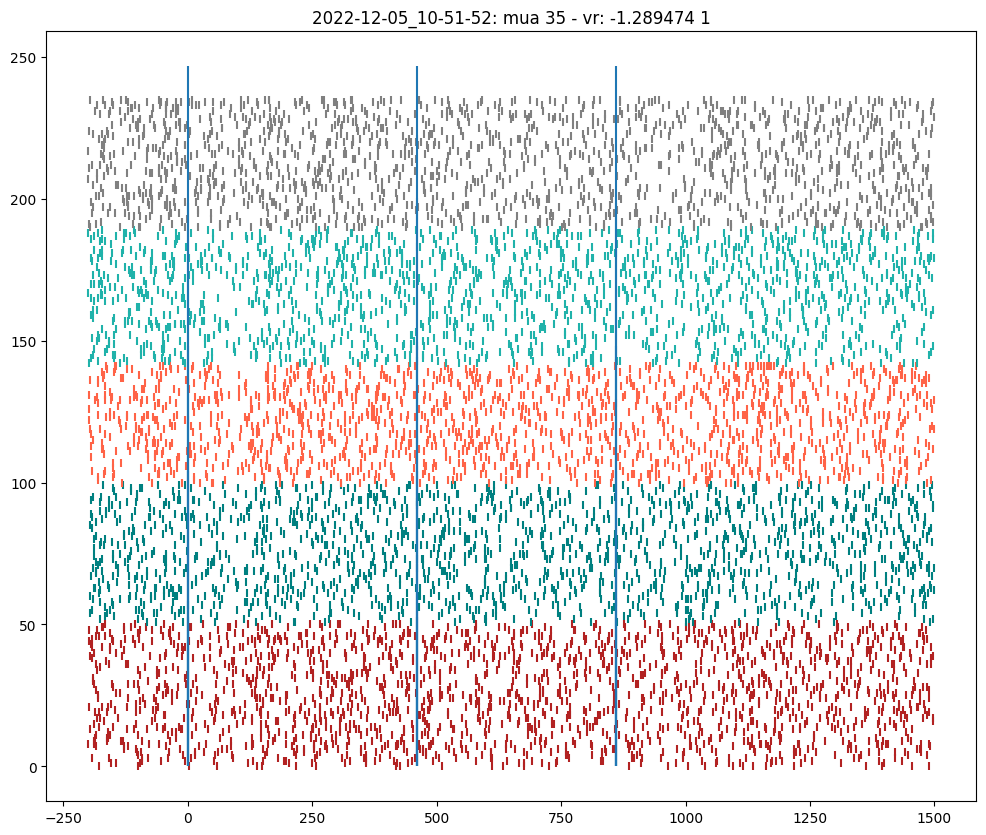

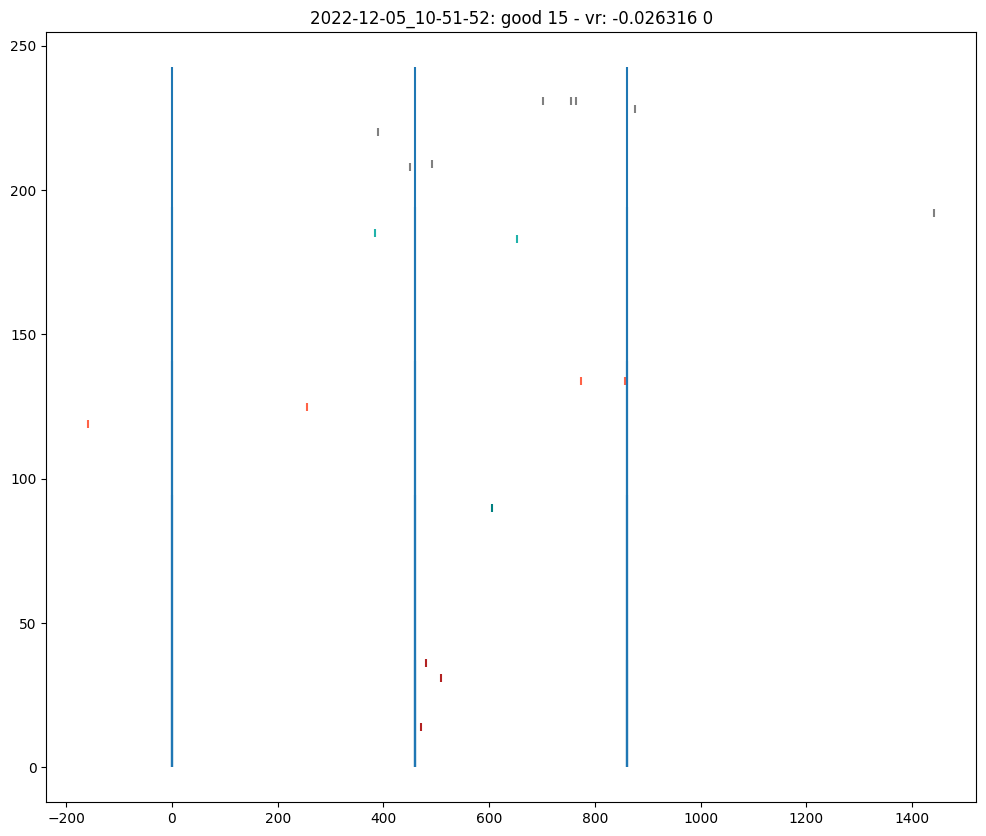

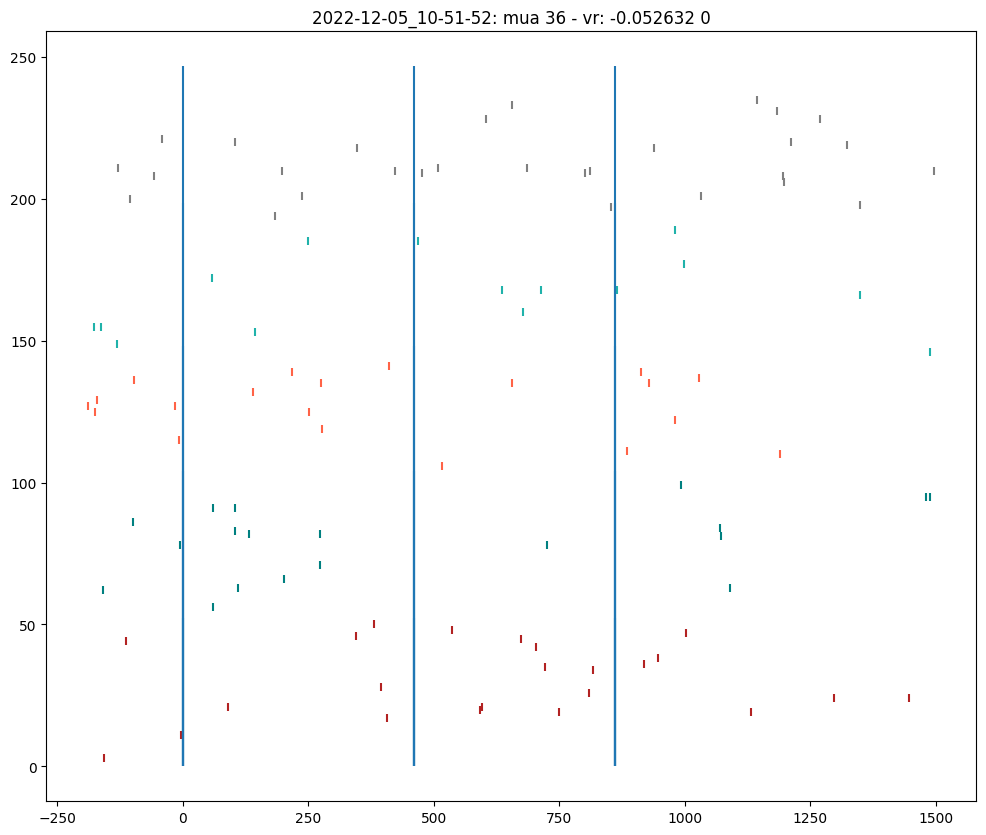

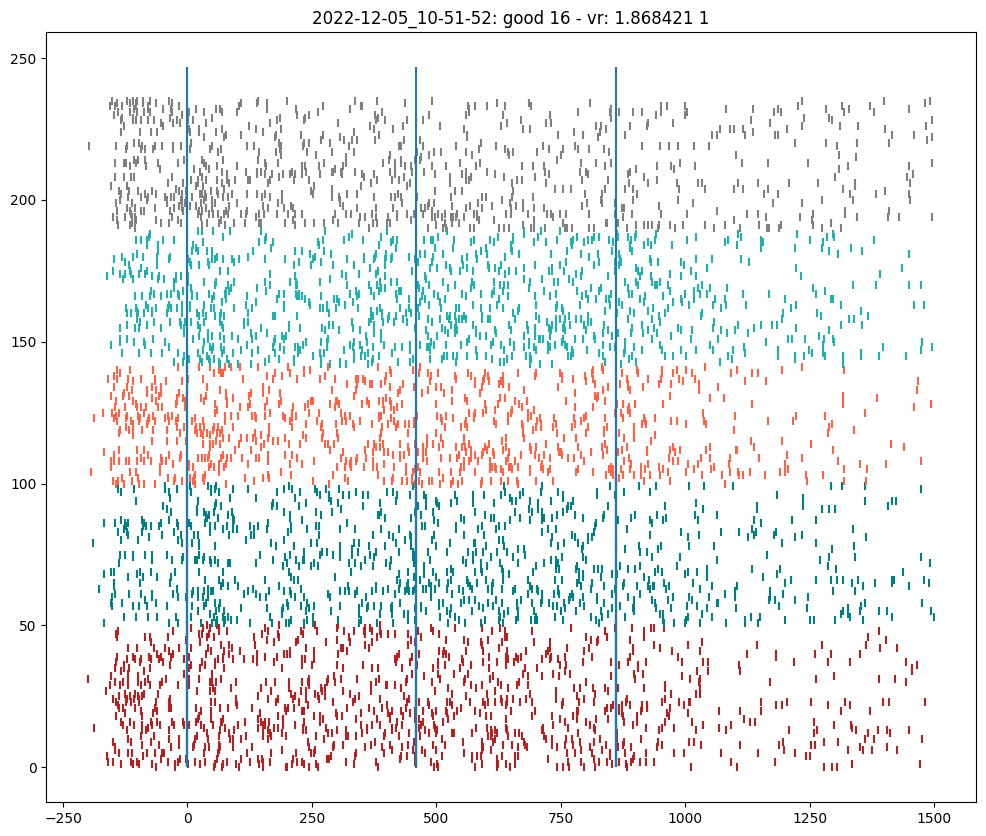

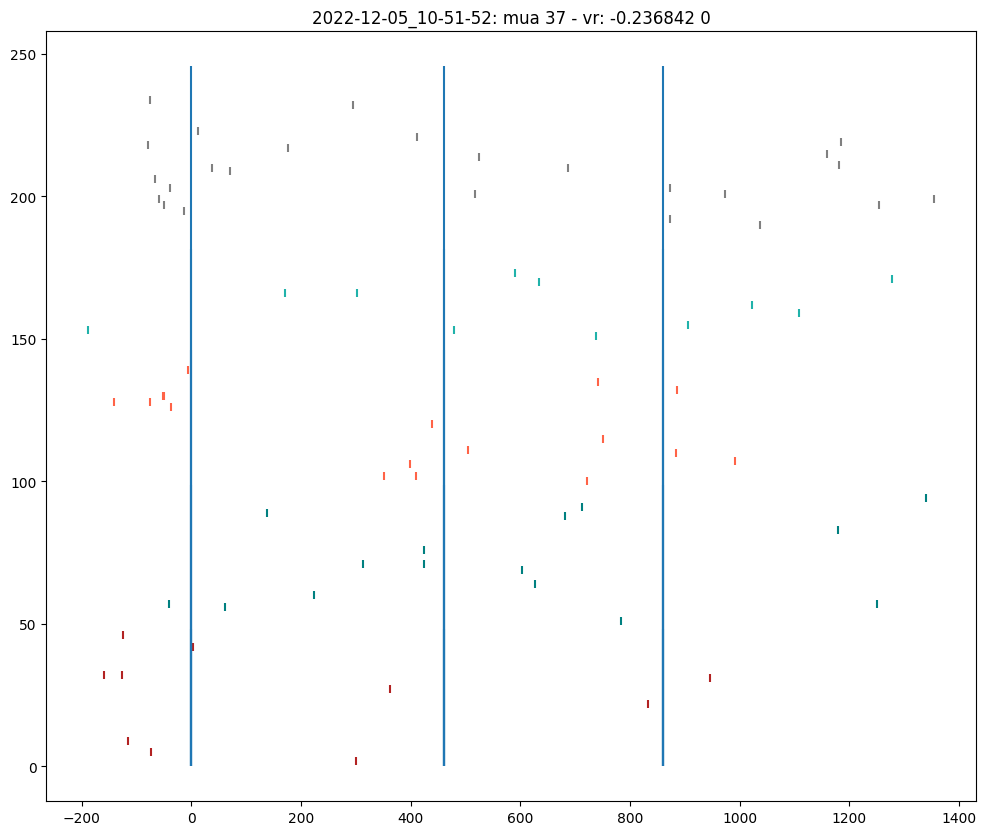

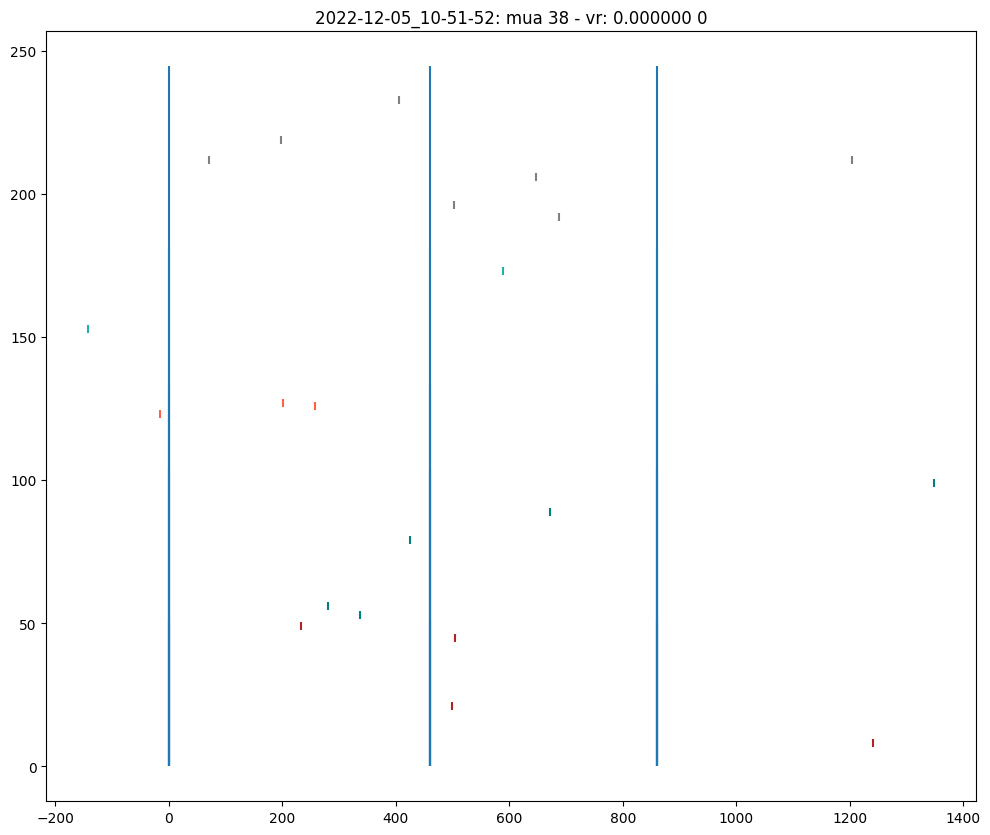

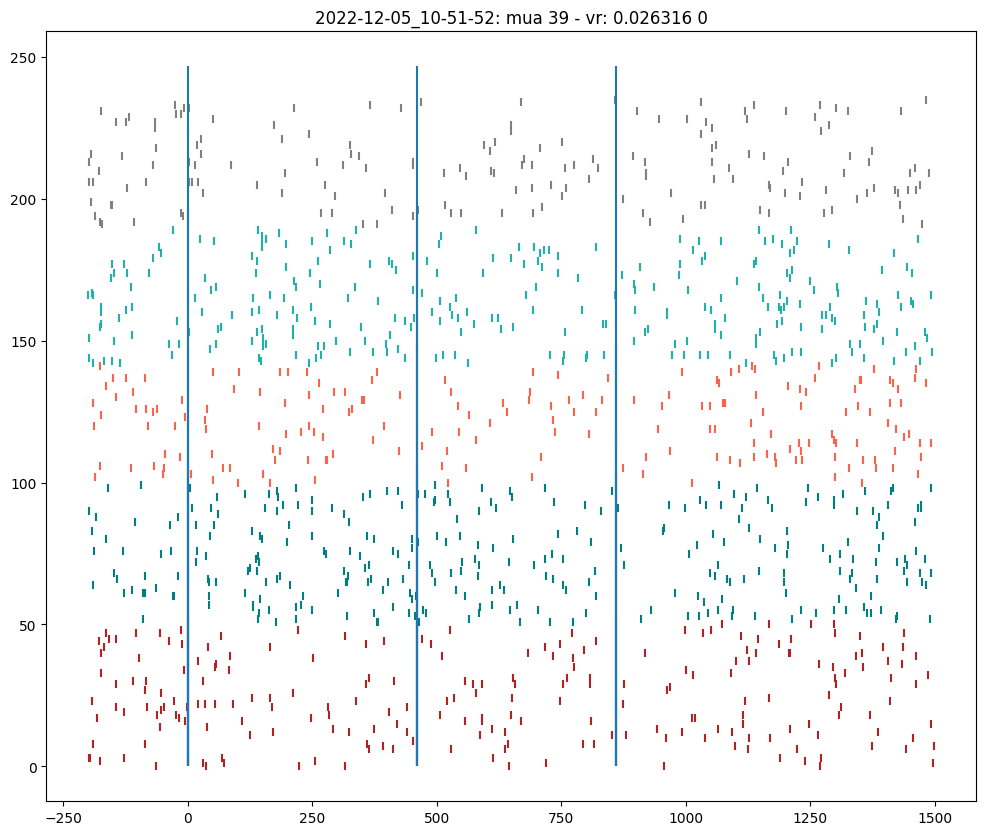

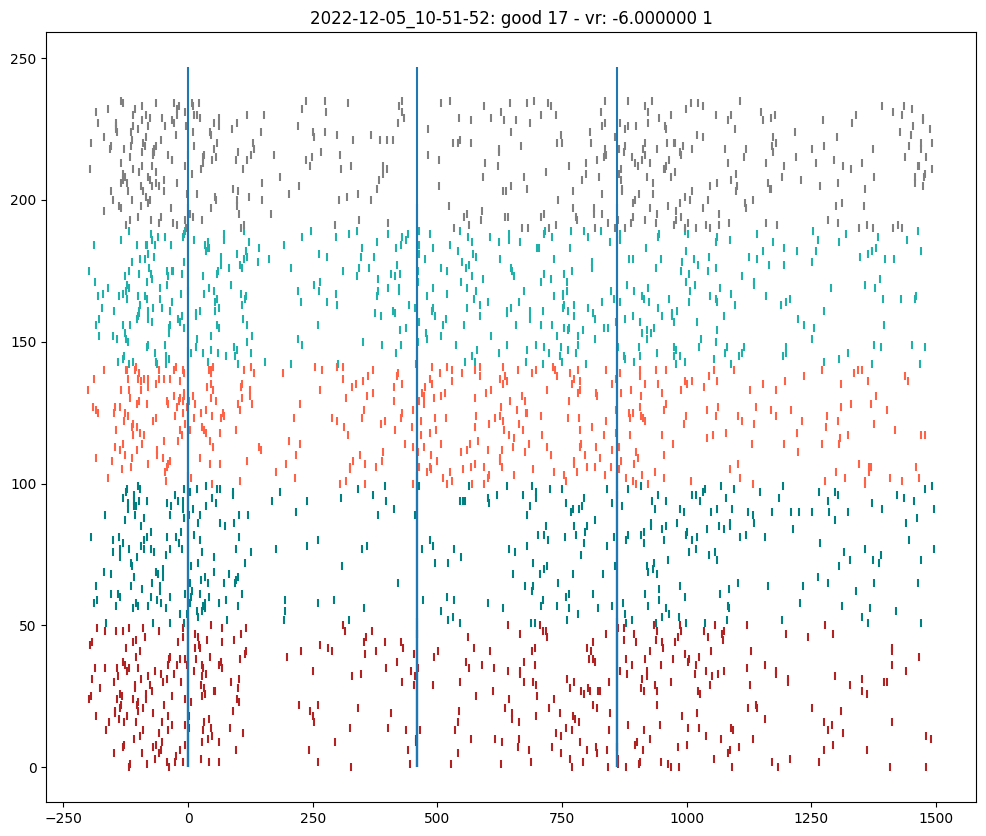

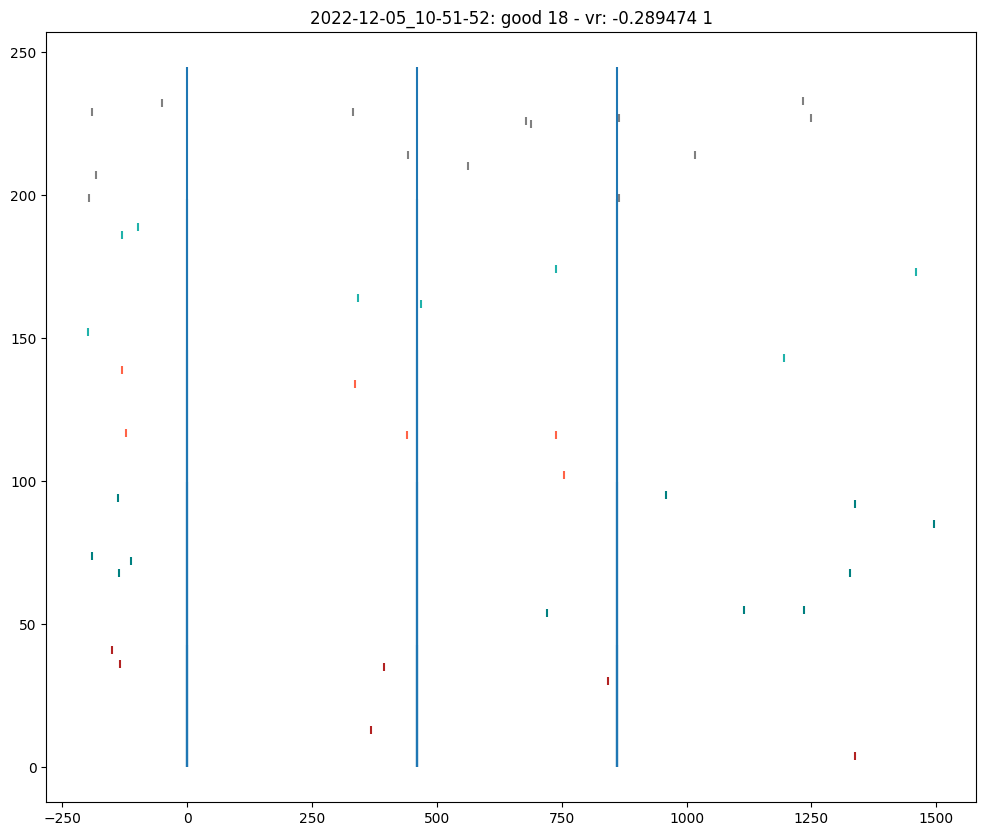

In [58]:


for i_n in range(len(units_info[area])):
    f,ax=plt.subplots(figsize=(12,10))
    n_trials=0
    for key in ['11','15','51','55','0']:
        # ----- plot conv----------
        # ax1.plot(time, conv[key], color=colors[key])
        # ----- plot spikes----------
        sp=units_info[area][key][i_n][:,idx_start:idx_end]
        rows, cols = np.where(sp >= 1)
        ax.scatter(cols+start,rows+n_trials, marker='|', alpha=1,edgecolors='none',color=colors[key],label="sample %s" % key)
        ax.vlines([0,460,860],0,ax.get_ylim()[1])
        n_trials = n_trials + sp.shape[0] 
    i_unit =units_info[area]
    ax.set(title='%s: %s %d - vr: %f %d'%(session,i_unit['unit_type'][i_n],i_unit['n_type'][i_n],i_unit['vr_in'][i_n],i_unit['vr_in_sig'][i_n]))
